#                                AI IMAGE CLASSIFIER

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from pygoogle_image import image as pi
import random
import PIL
import pickle 

In [115]:
pi.download(keywords="ai generated images", limit=100, directory='./ai_generated/')
pi.download(keywords="ai generated art", limit=100, directory='./ai_generated/')
pi.download(keywords="ai generated characters", limit=100, directory='./ai_generated/')
pi.download(keywords='stable diffusion', limit=100, directory='./ai_generated/')
pi.download(keywords='dalle2 generated images', limit=100, directory='./ai_generated/')
pi.download(keywords='midjourney', limit=100, directory='./ai_generated/')
pi.download(keywords='fake images', limit=999, directory='./ai_generated/')
pi.download(keywords='landscapes', limit=100, directory='./real/')
pi.download(keywords='cityscapes', limit=100, directory='./real/')
pi.download(keywords='animals', limit=100, directory='./real/')
pi.download(keywords='vehicles', limit=50, directory='./real/')
pi.download(keywords='traffic', limit=50, directory='./real/')
pi.download(keywords='offices', limit=50, directory='./real/')
pi.download(keywords='real food images', limit=50, directory='./real/')
pi.download(keywords='real images', limit=999, directory='./real/')
pi.download(keywords='random images', limit=100, directory='./real/')


[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[=======================================


CIFAKE: Real and AI-Generated Images

In [2]:
data = "./dataset/"
categories = ['Real', 'AIGenerated']

In [3]:
img_size = 48

In [4]:
img_size = 48
training_data = []

i = 0
for category in categories:
    category_path = os.path.join(data, category)
    classes = categories.index(category)

    for root, dirs, files in os.walk(category_path):
        for img in files:
            if not img.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(root, img)
            img_array = cv.imread(img_path)
            if img_array is None:
                print(f"Skip: {img_path} (cannot read)")
                continue

            new_array = cv.resize(img_array, (img_size, img_size))
            new_array = new_array / 255.0
            training_data.append([new_array, classes])
            i += 1

print(f"Total images processed: {i}")

Total images processed: 21473


In [5]:
len(training_data), training_data[0][0].shape

(21473, (48, 48, 3))

In [6]:
random.shuffle(training_data)

In [7]:
X_train = []
y_train = []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

In [8]:
X_train.shape

(21473, 48, 48, 3)

In [9]:
y_train.shape

(21473,)

In [10]:
X_train[0].shape

(48, 48, 3)

#### Storing X_train and y_train

In [11]:
pickle_out = open("X_train.pickle", "wb")
pickle.dump(X_train, pickle_out, protocol=4)
pickle_out.close()

pickle_out = open("y_train.pickle", "wb")
pickle.dump(y_train, pickle_out, protocol=4)
pickle_out.close()

In [12]:
pickle_in = open("X_train.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

In [13]:
X_train.shape

(21473, 48, 48, 3)

In [14]:
y_train.shape

(21473,)

## Creating the Model

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential

In [16]:
model = keras.Sequential([
    keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (48,48,3)),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(256,(3,3), activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 409,089 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

## Model Plot

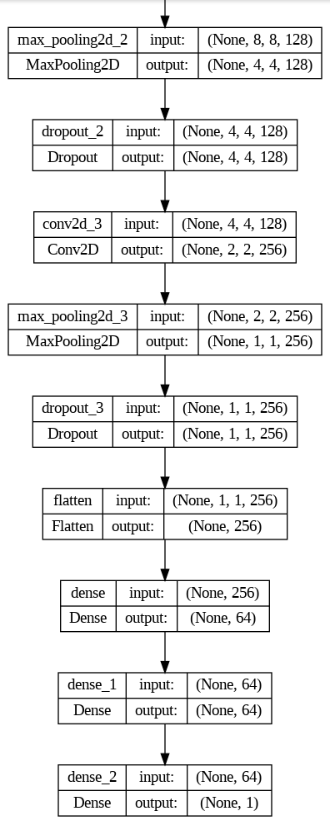

## Training the Model

In [18]:
history = model.fit(X_train, y_train, epochs=15)

Epoch 1/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 64s 87ms/step - accuracy: 0.6173 - loss: 0.6423
Epoch 2/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.7467 - loss: 0.5182
Epoch 3/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 54s 81ms/step - accuracy: 0.7985 - loss: 0.4374
Epoch 4/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 56s 84ms/step - accuracy: 0.8127 - loss: 0.4100
Epoch 5/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 60s 89ms/step - accuracy: 0.8433 - loss: 0.3612
Epoch 6/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.8567 - loss: 0.3301
Epoch 7/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.8534 - loss: 0.3286
Epoch 8/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 56s 83ms/step - accuracy: 0.8710 - loss: 0.3021
Epoch 9/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 87s 90ms/step - accuracy: 0.8798 - loss: 0.2867
Epoch 10/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.8825 - loss: 0.2740
Epoch 11/15
672/672 ━━━━━━━━━━━━━━━━━━━━ 79s 74ms/step - accuracy: 0.8828 - loss: 0.2746
Epoch 12/15
672/672 ━━━━━━━━━━

### Storing the Model

In [19]:
model.save("AIGeneratedModel.h5")

In [20]:
model_new = keras.models.load_model("AIGeneratedModel.h5")

In [21]:
data = "./dataset/"
categories = ['Real', 'AIGenerated']

img_size = 48
testing_data = []

i = 0
for category in categories:
    category_path = os.path.join(data, category)
    classes = categories.index(category)

    for root, dirs, files in os.walk(category_path):
        for img in files:
            if not img.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(root, img)
            img_array = cv.imread(img_path)
            if img_array is None:
                print(f"Skip: {img_path} (cannot read)")
                continue

            new_array = cv.resize(img_array, (img_size, img_size))
            new_array = new_array / 255.0
            testing_data.append([new_array, classes])
            i += 1

print(f"Total testing images processed: {i}")

# Shuffle & split
random.shuffle(testing_data)

X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

Total testing images processed: 21473


In [22]:
model_new.evaluate(X_test, y_test)

672/672 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9254 - loss: 0.1966


[0.19398848712444305, 0.9278163313865662]

In [23]:
y_pred = model_new.predict(X_test)

672/672 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step


In [24]:
X_test.shape

(21473, 48, 48, 3)

In [25]:
y_test.shape

(21473,)

In [26]:
y_pred.shape

(21473, 1)

In [27]:
y_predicted = []

for arr in y_pred:
    if arr[0] <= 0.5:
        y_predicted.append(0)
    else:
        y_predicted.append(1)

y_predicted = np.array(y_predicted)

In [28]:
y_predicted.shape

(21473,)

### Printing the Classification Report

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     10567
           1       0.96      0.89      0.93     10906

    accuracy                           0.93     21473
   macro avg       0.93      0.93      0.93     21473
weighted avg       0.93      0.93      0.93     21473



In [30]:
import matplotlib.pyplot as plt

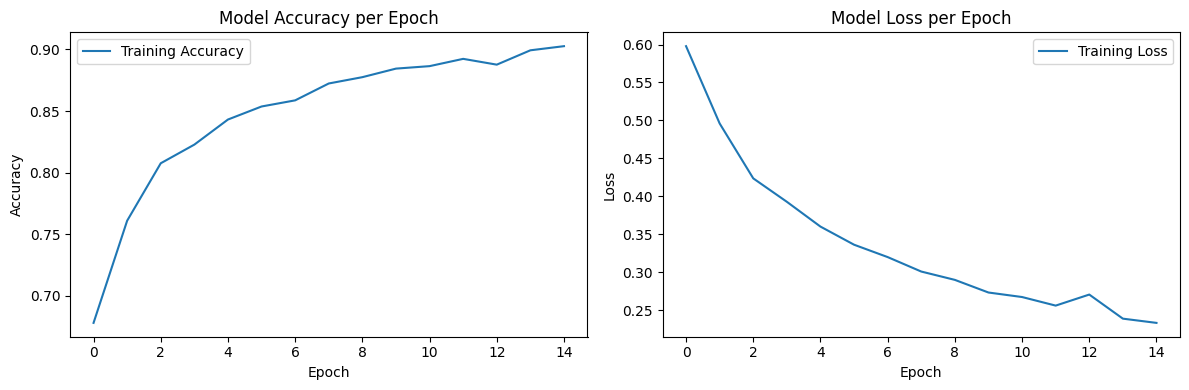

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Testing 

In [32]:
def find_out(path_img):
    img_arr = cv.imread(path_img)
    plt.imshow(img_arr)
    new_arr = cv.resize(img_arr, (48,48))
    new_arr = new_arr/255
    test = []
    test.append(new_arr)
    test = np.array(test).reshape(-1, img_size, img_size, 3)
    y = model_new.predict(test)
    if y[0] <= 0.5:
        print("The given image is AI Generated.")
    else:
        print("The given image is Real.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
The given image is AI Generated.


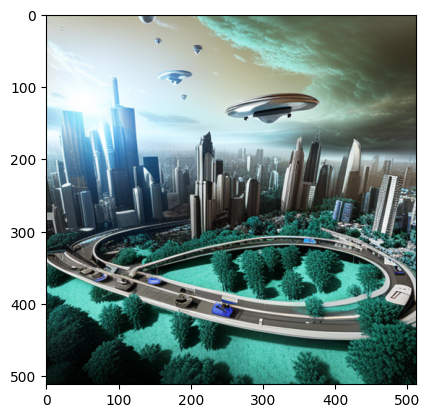

In [33]:
path_img = './Testing/ai4.png'
find_out(path_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
The given image is Real.


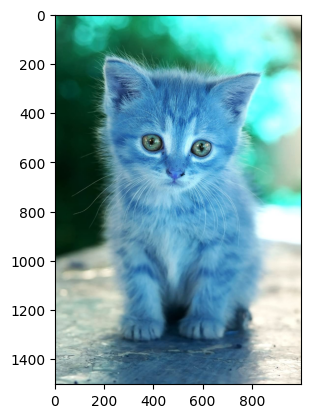

In [34]:
path_img = './Testing/real2.jpeg'
find_out(path_img)